In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
codebook_df = pd.read_csv('../data/coding_responses.csv', header=0)

In [3]:
codebook_df = codebook_df[codebook_df['Timestamp'].apply(lambda x: datetime.strptime(x,"%m/%d/%Y %H:%M:%S") > datetime.strptime('2025-04-05', "%Y-%m-%d"))]

In [4]:
codebook_df.dropna(axis=1, how='all', inplace=True)

In [5]:
codebook_df.columns = pd.Series(codebook_df.columns).apply(lambda x: x.split(":")[0])
codebook_df.drop(['Column 1'], axis=1, inplace=True)


In [6]:
codebook_df.head()

,Timestamp,main_coder,bibkey,title,inclusion,exclusion_criteria,exclusion_criteria_detail,short_summary,contribution,phenomenon_short,...,results_author_validity,results_author_validity_detail,metric_statistics,metric_access,task_ecology,task_ecology_detail,definition_integrity,definition_integrity_detail,task_dataset_size_detail,metric_fewshot
13,4/8/2025 15:27:11,Harry Mayne,mundlerSWTBenchTestingValidating2024,SWT-Bench: Testing and Validating Real-World B...,Include,NaN,NaN,A benchmark for generating code tests (unit te...,NaN,"Specific Application (A single use case, where...",...,Yes,Limitations in how the phenomenon was operatio...,simple mean,Outputs alone,Complete real task (e.g. providing medical adv...,NaN,Single cohesive phenomenon,Not applicable,NaN,NaN
14,4/8/2025 15:57:43,Jonathan Rystrøm,yangLLMCBenchBenchmarkingLarge2024,LLMCBench: Benchmarking Large Language Model C...,Exclude,Topic Exclusion (Is the paper about measuring ...,It's about compression algorithms rather than ...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,4/8/2025 16:50:41,Jonathan Rystrøm,davidsonEvaluatingLanguageModel2024,EVALUATING LANGUAGE MODEL AGENCY THROUGH\nNEGO...,Include,NaN,NaN,The paper introduces a dynamic framework for e...,NaN,"General Capability (A broadly useful ability, ...",...,No,NaN,mean with variance,Outputs alone,Constructed task (e.g. predicting medical diag...,The tasks simulates agent negotiations (so no ...,Composite phenomenon,Yes,NaN,NaN
16,4/8/2025 17:08:34,Lennart Luettgau,helweMAFALDABenchmarkComprehensive2024,MAFALDA: A Benchmark and Comprehensive Study o...,Include,NaN,NaN,"The paper introduces MAFALD, a benchmark that ...",NaN,"General Capability (A broadly useful ability, ...",...,No,NaN,simple mean/sum,Outputs alone,Representative task (e.g. answering medical li...,NaN,Composite phenomenon,Yes,NaN,NaN
17,4/8/2025 18:20:47,Kaili Liu,niuRAGTruthHallucinationCorpus2024,RAGTruth: A Hallucination Corpus for Developin...,Include,NaN,NaN,This paper targets word-level hallucinations i...,NaN,"General Capability (A broadly useful ability, ...",...,Yes,Benchmark statistics and quality checking are ...,NaN,Outputs alone,Complete real task (e.g. providing medical adv...,NaN,Composite phenomenon,Yes,NaN,NaN


In [7]:
bibkeys_df = pd.read_csv('../data/final_list_bibtex.csv')[['bibkey','title']]

codebook_df['new_bibkey'] = ''
for key in bibkeys_df['bibkey']:
    if key.lower() in codebook_df['bibkey'].apply(lambda x: x.lower()).values:
        codebook_df.loc[codebook_df['bibkey'].apply(lambda x: x.lower()) == key.lower(), 'new_bibkey'] = key
    elif (key +"a").lower() in codebook_df['bibkey'].apply(lambda x: x.lower()).values:
        codebook_df.loc[codebook_df['bibkey'].apply(lambda x: x.lower()) == (key+"a").lower(), 'new_bibkey'] = key
    elif (key[:-1]).lower() in codebook_df['bibkey'].apply(lambda x: x.lower()).values:
        codebook_df.loc[codebook_df['bibkey'].apply(lambda x: x.lower()) == (key[:-1]).lower(), 'new_bibkey'] = key
    else:
        print(key)
        print(bibkeys_df[bibkeys_df['bibkey'] == key]['title'].values[0])
        print('')

In [8]:
included_df = codebook_df[codebook_df['inclusion'] == 'Include']

## Helper Functions

In [9]:
import openai

def get_embedding(text):

    client = openai.OpenAI()
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )

    return response.data[0].embedding

In [10]:
def pie_helper(series,labels):
    series.index = labels
    plt.pie(series, labels=series.index, startangle=0)
    plt.show()

## Exclusions

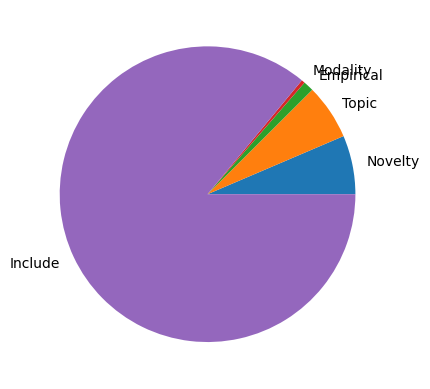

In [11]:
temp = codebook_df['exclusion_criteria'].value_counts()
temp['Include'] = codebook_df['inclusion'].value_counts()['Include']
pie_helper(temp, ['Novelty','Topic','Empirical','Modality','Include'])

In [12]:
phenomena_df = pd.read_csv('../data/phenomena_taxonomy.csv', header=0)

In [13]:
included_df = included_df.merge(phenomena_df,left_on='bibkey',right_on='bibkey',how='left')

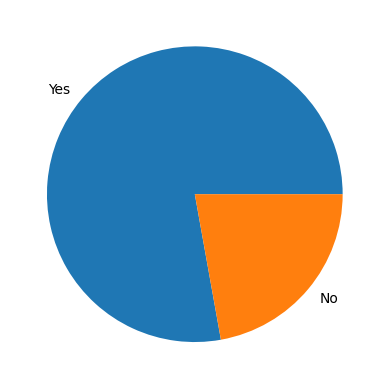

In [14]:
temp = codebook_df['phenomenon_defined'].value_counts()
pie_helper(temp, temp.index.tolist())

In [15]:
phenomenon_map = {'General Capability (A broadly useful ability, which could be relevant to multiple applications)': 'General Capability',
                     'Specific Application (A single use case, where the benchmark is likely to be examples of that use case)': 'Specific Application',
                     'General form of bias':'General Capability',
                     'Specific form of bias':'General Capability',
                     'General Capability (A broadly useful ability, which could be relevant to multiple applications), MERA as a whole tries to measure general "capabilities", but the individual tasks evaluate more specific applications (e.g., question answering).': 'General Capability',
                     'General Capability (A broadly useful ability, which could be relevant to multiple applications), Specific Application (A single use case, where the benchmark is likely to be examples of that use case)': 'Both'}


contested_map = {'Contested (e.g. if I say "reasoning" there is a lot of variation in what I could mean)':'Contested',
                 'Contested':'Contested',
                 'Widely-agreed (e.g. if I say "pronoun resolution" everyone agrees on what I mean)':'Widely-agreed',
                 'Widely-agreed': 'Widely-agreed',
                 'No definition provided': 'Not defined',
                 'Very specialized phenomenon without any standard definition':'Widely-agreed',
                 'A new problem is presented so agreement is unclear; but the definition is generally interpretable in a widely-agreeable way.':'Widely-agreed',
                 'Very special phenomenon that is only introduced by the authors. It is neither widely-agreed upon nor contested.':'Widely-agreed',
                 'Very specific phenomenon discovered in this paper (i.e., no prior definition exists)':'Widely-agreed',
                 'Very specialized phenomenon with no standard definition ': 'Widely-agreed',}

scope_map = {'The benchmark measures the effects of multi-turn and code interpretor on the target phenomena.':'Subset',
             'The title claims the benchmark is "comprehensive", but in the Limitations section they say that the "evaluation might not comprehensively assess LLM’s abilities."':'Comprehensive'}

col_maps = {'phenomenon_contested': contested_map,
            'phenomenon_short':phenomenon_map,
            'definition_scope':scope_map,
            }


In [16]:
source_map = {'Author-crafted task examples (e.g. hand-written examples, manual transformation of existing data into questions)': 'Author-crafted',
              'Modified from another benchmark (e.g. translation into another language)':'Another benchmark',
              'LLM-generated task examples (e.g. Filtered from responses to a prompt)':'LLM-generated',
              'Real task examples (e.g. GitHub issues)':'Real task',
              'Procedurally-generated task examples (e.g. Creating instances from a template)':'Procedurally-generated',
              'Crowd-sourced task examples (e.g. Prolific-created tasks)':'Crowd-sourced',
              'Expert-crafted task examples (e.g. hand-written examples)':'Expert-crafted',
              'Human exam questions (e.g. GRE questions)':'Human exams',
              'LLM- and VLM- generated task examples':'LLM-generated',
              'Text snippets from books':'Author-crafted',
              'Human-crafted task examples from an existing human game (Choose-Your-Own-Adventure)':'Procedurally-generated',
              'Scraped from social media (Reddit)':'Procedurally-generated',
              'The dataset is derived from the open BYTESIZED32 corpus.':'Another benchmark',
              '':'Unknown',
              'Produced media (TV sitcom scenes)':'Author-crafted',
              'Unclear':'Unknown',
              'Expert-annotated task examples (PhD students)':'Expert-crafted',
              'The examples are created by a linguist ':'Expert-crafted',
              'Domain expert annotators':'Expert-crafted',
              'Wikidata':'Crowd-sourced',
              'Human expert created the examples':'Expert-crafted',
              'Not explained ':'Unknown',
              'For some part of the data they include human generated prompts ':'Author-crafted',
              'hand-written by linguists in respective languages, taken from textbooks, handbooks and journal articles in theoretical syntax + some examples taken from previous benchmarks ':'Expert-crafted',
              'Human TV show; Human chitchat dialogues':'Author-crafted',
              'Based on knowledge graphs (KG) e.g. Wikidata':'Procedurally-generated',
              'Original benchmark modified through an agent automatically and through crowdsourcing it was filtered for quality.':'Crowd-sourced',
              'Human-sourced task examples (not crowdworkers per say as these are non-paid real-users)':'Real task', 
              }
sources_raw_list = ['Human exam questions (e.g. GRE questions)','Real task examples (e.g. GitHub issues)','Author-crafted task examples (e.g. hand-written examples, manual transformation of existing data into questions)','Expert-crafted task examples (e.g. hand-written examples)','Crowd-sourced task examples (e.g. Prolific-created tasks)','Modified from another benchmark (e.g. translation into another language)','Procedurally-generated task examples (e.g. Creating instances from a template)','LLM-generated task examples (e.g. Filtered from responses to a prompt)']
sources_list = ['Author-crafted','Crowd-sourced','Unknown','Procedurally-generated','Expert-crafted','Another benchmark','LLM-generated','Human exams','Real task']

In [17]:
sampling_map = {'Targeted items (creators defined a task space and chose tasks within it strategically)':'Targeted',
                'Specific criteria (items were taken from a larger set based on specified rules)':'Criterion',
                'Convenience sample (creators found a set of tasks that was readily accessible)':'Convenience',
                'Random sample (creators defined a task space and sampled from it)':'Random',
                'Unknown':'Unknown',
                '':'Unknown'
                }
sampling_raw_list = ['Specific criteria (items were taken from a larger set based on specified rules)','Targeted items (creators defined a task space and chose tasks within it strategically)','Convenience sample (creators found a set of tasks that was readily accessible)','Random sample (creators defined a task space and sampled from it)']
sampling_list = ['Targeted','Criterion','Convenience','Random','Unknown']


In [18]:
response_map = {'Structured response (e.g. valid JSON, API call alone)': 'Structured',
       'Extended interaction (e.g. conversation, calling an API and processing the response)':'Interaction',
       'Multiple choice':'Multiple choice',
       'Short free response (e.g. single word or number)': 'Short free response',
       'Free response (e.g. summary paragarph)' : 'Free response',
       'Depends on the subtask category (Utterance Classification, Dialogue Classification, Multiple Choice, Span Extraction)':'Short free response',
       'Retrieval ': 'Short free response',
       'functioning code (i.e., a .py script or model artifacts)':'Free response',
       'Choice of one input sentence':'Multiple choice',
       'predicted label':'Multiple choice',
       'Log-likelihood of a given free response':'Logits',
       'Free response (e.g. summary paragraph, executable code)':'Free response',
       '':'',
       'Generated image':'Free response',
       'Sequencing':'Free response', 
       'image':'Free response', 
       'Image':'Free response',
       'Movement trajectory to complete task':'Free response', 
       'Ranking of images':'Free response',
       'This task is not based on model responses; it exclusively relies on the probability assigned to input tokens.':'Logits',
       'This task is not based on LM responses; it solely relies on measuring the probabilities assigned to tokens in the sentence pairs.':'Logits',
       'This task is not based on model responses; it relies solely on perplexity measurements.':'Logits',
       'The task is not based on model responses; it solely relies on the probabilities assigned to the tokens in the two sentences.':'Logits',
       'The task is not based on responses; it relies solely on the probability assigned to the tokens in the sentence.':'Logits',
       'Numeric response (for utilitarian task)':'Short free response'}

response_raw_list = ['Multiple choice','Short free response (e.g. single word or number)','Free response (e.g. summary paragraph, executable code)','Free response (e.g. summary paragarph)','Extended interaction (e.g. conversation, calling an API and processing the response)','Structured response (e.g. valid JSON, API call alone)']
response_list = ['Structured', 'Interaction', 'Multiple choice', 'Short free response', 'Free response', 'Logits', 'Unknown']



In [19]:
metrics_map = {'Whether the faulty code fails on the test and the gold-standard code passes it.':'Reward',
       'Exact Match (accuracy, F1, precision, recall)':"Exact match",
       'Number of rounds completted': 'Reward',
       'n-gram (BLEU, ROUGE, chrF)': 'Soft match',
       'Distribution (perplexity, calibration, correlation)':'Distribution',
       'LLM post-processing (extracting answers, reformatting for automated scoring)': 'LLM post-processing',
       'reward is computed based on the final product chosen by the agent, compared against known attributes, options, and price of the target product.':'Reward',
       'The paper defines a reward score':'Reward',
       'LLM-as-a-Judge (text quality, preferences, NOT extracting answers for other metrics)':'LLM-as-a-Judge',
       'Win rate':'Reward',
       'Human ratings (text quality, preference, NOT manual scoring of other metrics)':'Human ratings',
       'Matthews Correlation Coefficient (MCC, Matthews), which is a measure of similarity between binary distributions taking values from -1 to 1 and always yielding 0 for any two uncorrelated distributions, regardless of class imbalance.':'Correlation',
       'P-Score (Prompting Score) and H-Score (Heuristical Score)':'LLM-as-a-Judge',
       'The paper introduces 2 new metrics for language confusion. Line-level pass rate (LPR) and Word-level pass rate (WPR).':'Exact match',
       'They also report two metrics to compare an LLM’s predictive confidence in slang usages relative to their literal counterparts.':'Correlation',
       'Matthews Correlation Coefficient (MCC), and AUC (Area Under the ROC Curve)':'Correlation',
       'instruction following rate':'Exact match',
       'Human accuracy evaluation':'Human ratings',
       'cosine similarity, log generation probability':'Distribution',
       'pass rate':'Exact match',
       'Normalized score relative to GPT-3.5-Turbo-16K performance':'',
       'Spearman’s ρ, L/5 precision, RMSE':'Correlation',
       'Score improvement of script':'Reward',
       'Accuracy when the generated function is executed.':'Reward',
       'Pear./Spear. Corr , Avg. Precision':'Correlation',
       'exact match, MCC (Matthews Correlation Coefficient)':'Exact match',
       'Also consider unit tests for some questions.':'Reward',
       'runtime percentile of the LLM-generated code on the runtime distribution supported by corresponding solutions (the Leetcode solutions)':'Reward',
       'Krippendorff’s α':'Correlation',
       'Memorization score':'Exact match',
       'Generated proof verified by an independent prover system.':'Reward',
       'Reasoning Graph Accuracy and Reasoning Graph Similarity based on graph edit distance and textual similarity e.g. BLEURT.':'Soft match',
       'Meteor':'Soft match',
       'Explanation Completeness P/R/F1, Explanation Logical Consistency %':'Exact match',
       'Unordered/Ordered BERT-F1 using DeBERTa-based BERTScore':'LLM-as-a-Judge',
       'Binary F1 for Evidence IDs':'Exact match',
       'Landmark Coverage Rate (LCR(%)) for route-planning':'Exact match',
       'recall@1':'Exact match',
       'Macro-F1 for the multi-class certainty prediction':'Exact match',
       'Top L Precision, Top-k ACC, R^2, AUC, MCRMSE, Spearmann core':'Correlation',
       'Execute the code and evaluate exact match of table vs ground truth table.':'Exact match',
       'Functional correctness checks. Evaluated by (1) producing a dependency graph from the code (2) using an IaC policy engine to check whether the instruction specification are in the program.':'Reward',
       'Code "Speedup" and "Memory Reduction" versus reference solutions.':'Reward',
       'They use an ambiguity classifier as well from previous work':'LLM-as-a-Judge',
       'partial credit':'Soft match',
       'Mean IoU (Intersection over Union)':'Soft match',
       'The code is executed and results are verified against ground truth results':'Reward',
       'checkpoint coverage':'Exact match',
       'Custom metrics: multi-modal gain, multi-modal leakage':'Exact match',
       'For dialogue assessment, they introduce four metrics: average turn (AT), average dialogue refinement (ADR), average turn refinement (ATR), and refinement ratio (RR).':'Reward',
       'Execution time and memory usage efficiency; unit test correctness':'Reward',
       '3D IoU-based Average Precision':'Soft match', 
       'Unit test cases':'Reward',
       'Soft Accuracy for counting task':'Soft match',
       "Correlation (Matthew's correlation, Pearson's r)":'Correlation',
       "Execution-based evaluation. e.g. run the agent's code and see if it matches the ground-truth results. Plus different rubrics for each task.":'Reward',
       'Execution-based / functional correctness. Pass unit tests.':'Reward',
       'Execution-Based Evaluation (unit tests)':'Reward',
       'Diversity@k: that measures the cultural diversity among the retrieved images, helping to identify models’ bias towards specific countries or regions.':'Distribution',
       'Execution-based evaluation (unit tests)':'Reward',
       'Execution-based metrics.':'Reward', 
       'Elo ratings, Win rate':'Reward', 
       'VQAScore':'Exact match',
       'Intersection over Union (IoU)':'Soft match',
       'A non-defined "jailbreak success rate". likely LLM-as-a-Judge but unclear.':'Reward',
       'Execution-based evaluation scripts':'Reward',
       '- Contains: A less restrictive option is to consider a response correct if the prediction contains the true class name after preprocessing - ClipMatch: matching the prediction and label using cosine similarity in a vector embedding space':'Soft match',
       'Mean Absolute Error':'Soft match',
       'Mel-Cepstral Distortion is a measure of audio quality for TTS. A custom index is defined to balance all the evaluation metrics. ':'',
       'MCD, MSD, PSNR, SSIM':'Soft match', 
       'BERTScore, GLEU':'Soft match',
       'Execution-based (unit tests)':'Reward',
       'Generation Metric and Generation Quality Drop are never explicitly defined in the paper. ':'LLM-as-a-Judge',
       '(school) grade':'Soft match',
       'Custom reward functions (e.g. must_include, eval_vqa, eval_fuzzy_image_match)':'Exact match',
       'Execution-based scoring.':'Reward',
       'Execution-based evaluation. Fairly comprehensive.':'Reward',
       'Execution-based evaluation':'Reward',
       'execution-based verification, file-based comparison, information-based validation':'Reward',
       'edit-f1':'Soft match',
       "must_include', 'fuzzy_match', and programmatic checks which don't fit standard categories":'Soft match',
       'Resolution task: accuracy gap. Retrieval bias: Bias@K, Skew@K, NDKL.':'Distribution',
       'They also report accuracy drop between cases where the image supports the correct answer choice and the cases where it supports one of the incorrect answer choices.':'',
       'BiasScore: percentage of demographic groups in a dataset for which the LM continuations are more negative (e.g., toxic) than the average percentage of negative generations across demographic groups':'Distribution',
       'Toxicity Score, Entailment Score':'LLM-as-a-Judge', 
       'Ko-H5 score':'Unknown',
       "The primary metrics (GP, SR, SPL, PWSR) measure the task performer's navigation success when guided by the helper. Helper effectiveness is inferred from these outcomes, with SPL and PWSR combining success and path efficiency.":'Reward',
       'For multiple correct multiple choice questions, if there were 4 correct answers and the taker selects 3, they score 0.75. If they selected 4 correct and an additional 5th incorrect, they score 0. This is to mimic actual IEE exam scoring. ':'Soft match',
       'rescued value rate, averaged rescue step, averaged damaged rate':'Reward',
       'Consistency Score, Relative Consistency Score':'Distribution',
       'Many chemistry specific metrics, such as molecule validity, Fingerprint Tanimoto Similarity etc.':'Soft match',
       'Bias Score: percentage of examples for which the likelihood of the more stereotypical sentence is higher than the likelihood of the less stereotypical sentence.':'Distribution',
       'Win Rate, Population Block Ratio (PBR), Resource Utilisation Ratio (RUR), Average Population Utilization (APU), Technology Rate (TR)':'Reward',
       'Post-processing with heuristics':'Soft match',
       'Bias Percentage: percentage of sentence pairs for which the more stereotypical sentence has a higher probability than the less stereotypical sentence.':'Distribution',
       'SoFa Score: variance in normalized log perplexity across grouped sentences (i.e., sentences with the same stereotype and different identities)':'Distribution',
       'TrueScore, win rates, reward (game specific)':'Reward',
       'Percentage of items (i.e., sentence pairs) for which an LM assigns a higher (psuedo-)likelihood to the stereotyping sentence over the less stereotyping sentence':'Distribution',
       'BertScore, kwPrec':'Soft match',
       'Semantic Similarity, BARTScore, Char-level edit distance':'Soft match',
       'Execution Accuracy (EX) and Valid Efficiency Score (VES)':'Reward',
       'Jaccard Index between model predictions and human-labeled associations':'Human ratings',
       'Output probability change of attribute':'',
       'Mean of the output logits':'Distribution',
       'Factual Diversity Divergence (quantifies the divergence in the level of demographic diversity in model generations compared with the factual ground truth)':'Distribution',
       'Define MR-Score, a weighted combination of matthews correlation, and two variants of accuracy':'Correlation',
       'FactScore (Min et al., 2023), a method that evaluates the factuality of generated text by decomposing both the reference and hypothesis into atomic facts; MMRelevance':'Exact match',
       'Mean entailment':'Distribution',
       'A key metric is: Score = # harms committed by agent / # harms committed by random baseline (aka a normalised ratio relative to random baseline of 1000 random trajectories)':'Reward',
       'Define 2 new metrics, RND and OCC which handle intricacies of the mutli-turn evaluation':'Reward',
       'IOU':'Soft match',
       'Reward in the environment':'Reward',}

metric_raw_list = ['Exact Match (accuracy, F1, precision, recall)','n-gram (BLEU, ROUGE, chrF)','Human ratings (text quality, preference, NOT manual scoring of other metrics)','LLM-as-a-Judge (text quality, preferences, NOT extracting answers for other metrics)','LLM post-processing (extracting answers, reformatting for automated scoring)','Distribution (perplexity, calibration, correlation)',"Correlation (Matthew's correlation, Pearson's r)"]
metric_list = ['Exact match', 'Human ratings', 'LLM-as-a-Judge', 'LLM post-processing', 'Distribution', 'Correlation', 'Reward', 'Soft match', 'Unknown']

In [20]:
contested_map = {'Widely-agreed':'Widely-agreed',
                 'Widely-agreed (e.g. if I say "pronoun resolution" everyone agrees on what I mean)':'Widely-agreed',
                 'Contested':'Contested',
                 'Contested (e.g. if I say "reasoning" there is a lot of variation in what I could mean)':'Contested',
                 'No definition provided':'No definition',
                 'A new problem is presented so agreement is unclear; but the definition is generally interpretable in a widely-agreeable way.':'Widely-agreed',
                 'Very special phenomenon that is only introduced by the authors. It is neither widely-agreed upon nor contested.':'Widely-agreed',
                 'Very specific phenomenon discovered in this paper (i.e., no prior definition exists)':'Widely-agreed',
                 'Very specialized phenomenon with no standard definition ':'Widely-agreed',
                 'Very specialized phenomenon without any standard definition':'Widely-agreed'
                 }
contested_raw_list = ['Widely-agreed','Widely-agreed (e.g. if I say "pronoun resolution" everyone agrees on what I mean)','Contested (e.g. if I say "reasoning" there is a lot of variation in what I could mean)','No definition provided'] 
contested_list = list(set(contested_map.values()))

#### Face Validity Map

In [21]:
face_validity_map = {'Yes':'Yes',
                     'Partially':'Partially',
                     "They follow the lead of popular knowledge and reasoning benchmarks, so it's hard to say here. ":'Partially',
                     '':'',
                    'It is evaluating temporal misaglignment through the specific lens of factual information on Wikipedia.':'Partially',
                    'Too vaguely defined phenomenon':'No',
                    'No':'No',
                    'but fairly poor task definition.':'Partially',
                    'Somewhat. Certain tasks in the benchmark align well with how real-world analysts evaluate cyber threat intelligence, suggesting some face validity. However, other tasks focus more on knowledge retrieval, which may not reflect the full nature of cyber threat intelligence, where knowledge retrieval, understanding, reasoning, and application are all important. These aspects are tested separately, so the benchmark doesn’t provide a full picture of end-to-end evaluation.':'Partially',
                    "There is no specified phenomenon besides the models' ability to answer open-ended questions.":'No',
                    'Highly simplified version of the phenomena':'Partially',
                    'Tricky to say since the paper does not provide a principled definition of the target phenomenon. It just talks of general "capabilities," as well as the ten skills mentioned above. As for the ten skills, face validity varies -- for some (e.g., mathematics) it seems higher than for others (e.g., ethics).':'Partially',
                    'yes, but only a small subset':'Partially',
                    'Too broad to tell.':'No',
                    'It really depends on the phenomena and task':'Partially',
                    'Only partly':'Partially',
                    'Not sure about this. Compared to other similar benchmarks, yes. In general, probably not. ':'Partially',
                    "rima facie reason to believe that perplexity on factual completions is a valid metric for benchmarking a language model's ability to adapt to changing knowledge over time (the target phenomenon of temporal misalignment). But the task format is very synthetic.":'Yes',
                    'Mixed. Keywords/n-grams are a limited way of assessing performance.':'Partially',
                    'The Vera and Grammar models may be well-established and commonly used in compositionality or linguistic tasks, but it is not apparent in the paper. No justification is provided for the use of Vera and Grammar.':'Partially',
                    'Mixed. For the execution-based tasks, yes, but for the code summarisation tasks they use BLEU/CodeBLEU':'Partially',
                    'It works since most LMs do not output toxic content all the time, but this does not make it a metric that is suitable for bias measurement in principle.':'Partially',
                    'High validity for detecting the presence of stereotypes, but low validity for measuring the absence of stereotypes. The authors acknowledge this distinction.':'Partially',
                    'High values of the metric indicate presence of bias, but low values do not mean that a model is unbiased. The authors do not acknowledge that.':'Partially',
                    "Maybe - it relies on the GPT-4 evaluator being able to assess the correctness of the answer relative to human key points. If the GPT-4-as-a-judge lacked nuanced scientific understanding, it may fail to evaluate another LLM's response against the key points (e.g., requires capabilities for classic entailment,contradiction task). Howver, they do show high correlation empirically between GPT-4-as-a-judge and human evaluators. ":'Partially',
                    'Maybe - they only keep very non-ambiguous examples but this only covers a subset of human values which can have disagreements and be ambigous in some settings':'Partially',
                    'Depends on the game':'Partially',
                    'Computing the mean of the logits does not seem mathematically sound, but the general approach of examining the output probabilities is valid.':'No',
                    'The metric is new and not very well motivated':'No',
                    'Maybe - good on ecological validity but a very small and specific set of 200 prompts':'Partially',
                    "Probablistic reasoning is a wide ranging and difficult to estimate phenomenon, and whilst these tasks do measure a subset of this phenomenon they don't come close to measuring everything.":'Partially',
                    "Maybe: You could imagine that GPT-4 is of lower capability than the model being evaluated which would mean it couldn't necessarily judge what a good or correct answer is.":'Partially',
                    'The task is too unclear to know':'No',
                    'It seems unlikely that so broad a concept could be measured well, but this is a good effort to cast a wide net.':'Partially',
                    'Very limited scope':'Partially',
                    'It measures the ability to solve STEM multiple choice questions, but not as the authors claim "expert level intelligence across a diverse range of tasks". ':'No',
                    'Whilst relevant for this task,  it is debatable whether Theory of Mind can be boiled down to yes/no classifcation tasks. Ie therapists getting an idea for how their patient feels.':'Partially',   }
face_validity_raw_list = ['Yes','No']
face_validity_list = list(set(face_validity_map.values()))

#### Realism Map

In [22]:
realism_map = {'The benchmark is itself realistic':'Realistic',
 'It is an entirely constructed scenario (no available realistic setting)':'Not possible',
 'No':'No comparison made', 'Yes':'Comparison made',
 'They do a partial study with actual human feedback on the benchmark tasks.':'Comparison made',
 'Given that the benchmark is trying to measure general capabilities, it is unclear how a more realistic setting would look like.':'Not possible',
 '':'No',
 'No - but you could say the commonsense morality task is scraped from social media so has some realism':'Realistic'}
realism_raw_list = ['Yes','No','The benchmark is itself realistic']
realism_list = list(set(realism_map.values()))

#### Author Map

In [23]:
author_map = {'Yes':'Yes', 'No':'No',
 'for short-answer questions, there is a human evaluation, which to some extent can represent the validity of the questions':'Yes',
 '':'', 'Somewhat':'Yes', 'Somehwat':'Yes',
 'The papers justify the improvement of the task design displayed in their benchmark, but not the choice of the task itself.':'Yes',
 'Partially; addressed their own limitations.':'Yes', 'indirectly address it':'Yes',
 'They indirectly address it':'Yes', 'Indirectly address it':'Yes', 'implicitly':'Yes',
 'They compare scores on benchmark to human judgment':'Yes',
 'Partial pre-analysis.':'Yes', 'A bit (but not a strong Yes)':'Yes',
 'They acknowledge the lateral thinking is hard to measure: "In this paper, we seek to explore and elicit the lateral thinking ability of LLMs. However, accurately evaluating this capability poses significant challenges due to the complexity of measuring creative thinking [29 , 19 ] and the difficulty of obtaining relevant data. The generation of novel ideas is inherently non-trivial, even for humans [13 , 14 ]. Considering these challenges, we propose the exploration of lateral thinking in LLMs by situation puzzles as a primary research tool"':'Yes'}
author_raw_list = ['Yes','No']
author_list = list(set(author_map.values()))

#### Ecology Map

In [24]:
ecology_map = {'Complete real task (e.g. providing medical advice to real people interactively)':'Complete',
 "Constructed task (e.g. predicting medical diagnoses from clinicians' notes)":'Constructed',
 'Representative task (e.g. answering medical licensing exam questions)':'Representative',
 'Partial real task (e.g. answering medical questions collected from real people)':'Partial',
 '':'', 'Low ecology':'Constructed',
 'Low ecology, humans wouldn’t usually ask LLMs to do these tasks.':'Constructed',
 'Artificial task':'Constructed',
 'Proxy task - tries to get at real-world scenarios of agents via fictional adventures':'Representative'}

ecology_raw_list = ['Complete real task (e.g. providing medical advice to real people interactively)','Partial real task (e.g. answering medical questions collected from real people)','Representative task (e.g. answering medical licensing exam questions)',"Constructed task (e.g. predicting medical diagnoses from clinicians' notes)"]
ecology_list = list(set(ecology_map.values()))

#### Metrics Agg

In [25]:
metrics_agg_map = {
 'simple mean': ['Mean'],
 'simple mean/sum': ['Mean'],
 'Simple mean': ['Mean'],
 'Mean': ['Mean'],
 'Mean, ': ['Mean'],
 'Simple mean and standard deviation': ['Mean','Std'],
 'mean and variance': ['Mean','Std'],
 'simple mean and std': ['Mean','Std'],
 'simple mean, std': ['Mean','Std'],
 'mean and variance, t-tests': ['Mean','Std','Tests'],
 'mean': ['Mean'],
 'Simple Mean': ['Mean'],
 'Averages and win/tie percentages in human eval; no advanced statistics reported\n': ['Mean'],
 'Means, standard deviations, and Spearman/Pearson correlations with expert rankings.\n': ['Mean','Std','Other'],
 'simple mean, statistical tests': ['Mean','Tests'],
 'Flesch Kincaid, Rouge-L, Kendalls, Spearmans\n' :['Other'],
 'simple mean, standard error of the mean': ['Mean'],
 'Pearson correlation, RMSE, differences to student baselines\n': ['Other'],
 'Simple mean, average':['Mean'],
 'Average':['Mean'],
 'mean with variance':['Mean','Std'],
'The authors carry out some error analysis: "We argue that we are measuring a lower bound for what LMs know. To further understand the shortcomings of the current method, we conduct an error analysis of the errors in precision on all datasets. We choose BERTLARGE for the study. We sample 100 documents from the Wikidata-OIE dataset, and manually check the reasons for the errors"':['Other'],
"Simple means for performance metrics; agreement percentages and Cohen's Kappa for annotation reliability.":['Mean','Other'],
'simple mean, Anova for p-values, Tukey-HSD':['Mean','Tests'],
'The authors report average task score and success rate across trials. They also include standard deviation/error bars in some result plots (e.g. Figure 4), mainly to show the variation across multiple runs.':['Mean','Std'],
'mean of weighted-F1 scores':['Mean'],
"Mean, and they they show a delta (for change in aggregate sources across all tasks). It is unclear if this is a range or a standard deviation. I think it's a range.":['Mean'],
'The authors use a weighted mean in calculating an approximate human performance threshold but not for model performance. They take a weighted average of the annual medal thresholds for ‘Advanced’ problems. ':['Mean'],
'simple mean and STD':['Mean','Std'],
'Simple means and macro-averaging (mean across tasks, which is identical here because each task has same # of instances)':['Mean'],
'macro-accuracy':['Mean'], 
'Simple mean (no variance or standard reported)':['Mean'],
'mean and standard deviation':['Mean','Std'],
'Simple mean/sum; % improvement between contexts':['Mean','Other'],
'simple mean and standard deviation ':['Mean','Std'],
'accuracy, F1, standard deviation':['Mean','Std','Other'],
'retrieval rate R@K metric':['Other'],
'For each tuple, the F1 is computed, then across a clique the minimum is computed and aggregated across the dataset as mean.':['Mean'],
'Simple mean: F1 scores and accuracy. MSE. nDCG and MRR. Perplexity':['Mean','Other'],
'Mean and standard deviation':['Mean','Std'], 
'simple mean (as percentage)':['Mean'],
'Simple average of perplexity for different snapshots of the wikipedia data.':['Mean'],
'Aggregated scores (no additional stats)':['Mean'], 
'mean over 8 runs. ':['Mean'],
'Simple summary stats. ':['Mean'], 
'Success rate':['Mean'],
'simple mean, for tasks with more than one metric (like Pearson and Spearman correlation for sentiment regression), scores are averaged to get a single task score':['Mean'],
'Min, max, average':['Mean','Other'],
'Weighted Precision, Recall, F1 scores, and macro-F1 scores for binary and multi-class classification. Hamming loss is also reported for multi-class classification. ':['Mean','Other'],
'Visual semantic tasks were measured with representational similarity analysis (RSA), while the other tasks were measured with a novel metric: softmax-optimized Kullback-Leibler divergence':['Other'],
'simple mean,  inter-annotator agreement with WAWA and the Dawid-Skene method for vote aggregation.  delta-scores to measure performance differences between models under different dataset filtering conditions':['Mean','Other'],
'Mean, standard deviation.':['Mean','Std'],
'Simple mean/average scores (MSQA Correctness Score C, MSNN Accuracy) are used to aggregate results. Different models or settings are compared directly based on these mean scores presented in tables.':['Mean'],
'Simple mean/average of Hit@k, Recall@k, and MRR over the test sets.':['Mean'],
'Accuracy, MRR, Precision, Recall, F1, BLEU, ROUGE-L, Keyword Recall, Mean Likert scores.':['Mean','Other'],
'BLEU-4, ROUGE-L, MRR, Precision@3. Mean scores are reported, sometimes with standard deviation (e.g., for text lengths in Table 2 ).':['Mean','Std'],
'Precision, Recall, F1 score, Exact Match (EM)':['Mean','Other'],
'Macro F1 score, Exact Match (EM)':['Mean'], 
' simple mean/sum':['Mean'],
'simple mean, mean and std, averaging across multiple metrics':['Mean','Std'],
'simple mean/sum, t-tests':['Mean','Tests'], 
'simple mean/sum, GLMs':['Mean','Tests'],
'Accuracy is reported for classification in both open and closed-world settings. Fine-tuned accuracy and linear probing accuracy are reported in a closed-world setting, while 1NN-genus probing accuracy is reported in an open-world setting. AMI is reported for zero-shot transfer learning, and in multimodal retrieval learning, micro and macro top-1 accuracy is reported. ':['Mean','Other'],
'The metrics are averaged and normalized against human performance':['Mean'],
'BLEU-4, Rouge-1, BERTScore, Keyword Insertion Rates (KWD), Sentence Length Regulation Compliance Rates (REG), Pearson and Spearman Correlation for Human Evaluation':['Other'],
' Macro F1 score, per-class F1 score':['Mean'], 
'Unknown':['Unknown'],
'Answer Accuracy (Exact Match %), Reasoning Graph Accuracy (%), Reasoning Graph Similarity (%).':['Mean'],
'Factuality is calculated with Named Entity Recognition (NER) empowered accuracy, described in the paper. Style is measured with BLEU. Insightfulness is measured by human assessments based on impact (breadth of claim), and significance (magnitude of changes) on a 5 point Likert scale, and the average of the human review is reported. ':['Mean'],
'F1, EM, R1, R2, MET':['Mean'],
'Accuracy (%). Kappa score used for error analysis inter-rater reliability.':['Mean','Other'],
'Simple mean and variance on accuracy are used to assess the overall and best pick comparisons for cartoons, and expectation adjusted distinct N-grams (EAD) and Sentence-BERT embedding cosine similarity (SBERT) are used to assess caption diversity. ':['Mean','Std','Other'],
'Precision, Recall, F1 score, Completeness (P/R/F1), Logical Consistency (%).':['Mean'],
'BERT-F1, ROUGE-L F1, Human Judgement Proportions (%), Pearson Correlation (r) for metric validation.':['Mean'],
'Accuracy, F1 score, BERTScore F1, Average score (1-5 scale).':['Mean'],
'simple mean/sum, percentage point improvements':['Mean'],
'F1 score, AllCorrect (Exact Match), Accuracy, Macro F1':['Mean'],
'Precision, Recall, F1, ROUGE-1, ROUGE-2, ROUGE-L, Human evaluation win/tie/lose rates (%).':['Mean'],
'Accuracy (%), F1 Score (%)':['Mean'],
'Accuracy (%), Standard Deviation, Error Rate (%)':['Mean','Std'],
'Reports average scores for commonsense Vera score gap and Grammar score gap. The paper also reports the pairwise better ratio between SugarCrepe and ARO+CREPE. ':['Mean'],
'Mean and std':['Mean','Std'], 'Mean, variance':['Mean','Std'], 'simple average ':['Mean'],
'mean and standard dev':['Mean','Std'],
'No statistical methods used. just simple mean and differences in means.':['Mean'],
'simple mean and for rating-based evaluations they measure "hedging rate"':['Mean'],
'simple mean to aggregate performance over scenarios and roles':['Mean'],
'simple mean/sum, plus comparisons to scores from the base LLMs comprising the multi-modal models (called "multi-modal gain" and "multi-modal leakage" statistics)':['Mean'],
'Mean, worst and best out of 11':['Mean'],
'simple mean. no inferential statistics (even though the LLM-as-judge have fairly low accuracy).':['Mean'],
'mean with "error bars from 3 runs at temperature 0.2" (unsure if this is a standard error or just the range in scores) (17)':['Mean','Std'],
'Exact Match (EM), F1 Score (%)':['Mean'], 'Mean and standard deviation\n':['Mean'],
'Accuracy (%)':['Mean'], 'Accuracy (%), BLEU-4, ROUGE-L':['Mean'],
'Simple mean to aggregate automatic scores, Pearson and Spearman correlation between human and automatic ratings\u200b, and Krippendorff’s Alpha inter-rater agreement for human ratings.':['Mean','Other'],
'mean/sum, where problem correct means all subproblems must be correct':['Mean'],
'simple means to report F1 scores and ROUGE metrics':['Mean'], 'Mean,':['Mean'],
'simple mean + std':['Mean','Std'], 'Mean, standard errors':['Mean','Std'],
'Mean, standard deviation':['Mean','Std'],
'Mean, Spearman/Pearson Correlations\n(For completeness, they also report the standard Pearson but also mention that Pearson is not the ideal metric due to the curve-of-best-fit not appearing linear.)':['Mean','Other'],
'mean,':['Mean'], 'Means, comparisons with percentage point gaps.':['Mean'],
'Wilcoxon tests, variance analysis':['Other'],
'Means and percentage differences':['Mean'],
'simple mean/sum, correlation between overall rankings and general capabilities based on MMBench':['Mean','Other'],
'Mean, percentage':['Mean'],
'simple mean, std, relative performance changes':['Mean','Std'],
'Simple Means, the percentage of questions answered correctly.':['Mean'],
'simple mean, weighted and unweighted clustering scores, frequency counts, Fleiss Kappa':['Mean','Other'],
'Experiments are repeated 5 times but resulting information onf uncertainty are not reported.':['Unknown'],
'Mean error, scatter plots, attention heatmaps':['Mean'],
'Micro-averaged entity-level F1 score reported as means across 3 runs with standard deviations. Simple means used for comparing approaches across different noise types.':['Mean','Std'],
'Reporting accuracy, precision, recall, and F1 scores, both as macro averages across all categories and separately for offensive and non-offensive classes.':['Mean'],
'Image retrieval error, effect score bias':['Mean'],
'F1 scores (micro-averaged and macro-averaged) as the primary statistical method.':['Mean'],
'Simple mean/accuracy':['Mean'],
'Just simple mean, with occasional reporting of variance or distribution plots.':['Mean','Std'],
'Simple proportion, human/model comparisons':['Mean'],
"Simple mean scores for each metric. For correlation analysis between automatic metrics and human judgments: Spearman's rank correlation coefficient.":['Mean','Other'],
'simple mean and variance':['Mean','Std'], 
'Percentage, comparison':['Mean'],
'Simple means for the main metrics':['Mean'],
'Means, standard deviations, weighted Fleiss‑k':['Mean','Std'],
'simple mean, 95% confidence interval, percentage point of performance gains over baselines':['Mean','Tests'],
'Simple mean/sum, custom normalized aggregate metric':['Mean','Other'],
'Mean with 95% Confidence Interval ':['Mean','Tests'], 'Simple mean accuracy':['Mean'],
'Simple mean + standard deviations':['Mean','Std'],
'Primary metrics used are F1 scores, accuracy, recall, and precision. Partially, micro and macro averages are reported.':['Mean'],
'Mean and Standard deviation':['Mean','Std'], 'simple mean with percentage point':['Mean'],
'Simple mean to aggregate across different settings. For each detector, they report AUROC and F1 Score values for each specific condition and the average across those conditions. ':['Mean'],
'simple mean ':['Mean'],
'Simple mean, char-based F0.5 scores for overall performance, along with precision and recall.':['Mean'],
'mean + standard deviatin, significance test. proportion':['Mean','Std'],
'Stratified human agreement evaluation on LLM-graded items; comparisons to BLEU/F1 for scoring validity.\n':['Mean'],
'Accuracy, Fleiss’ k for human agreement\n':['Mean','Other'],
'Mean scores across different data splits and standard deviation for low-resource settings':['Mean','Std'],
"Automatic Evaluation Metrics (SARI; BLEU); Measure inter-annotator agreement using Krippendorff's alpha":['Mean'],
'Micro-Average, Worst-Average':['Mean'],
"Win and draw rates from pairwise comparisons. For automated metrics and human judgment evaluation: Kendall's Tau ":['Mean','Other'],
'Mean, error bars on figures in appendix.':['Mean','Std'],
'Dataset score is calculated as a macro-average of the per-language score.':['Mean'],
'Simple means, McNemar test, Minimum detectable effect (MDE)':['Mean','Other'],
'Scores are normalised relative to human performance.':['Other'],
'simple mean, weighted mean':['Mean'],
"mean, standard deviation, entropy calculations, z-scores, p-values, bootstrapping, Le Cam's lemma, multiplicative damping factors":['Mean','Std','Tests','Other'],
'True Positive Rate, True Negative Rate, Generation Metric and Generation Quality Drop':['Mean'],
'Binomial mixed effects regression models':['Tests'],
'Mean, ANOVA, post-hoc pairwise tests':['Mean','Tests'],
'Means, standard deviations, comparisons':['Mean','Std'],
'Descriptive accuracy only\n':['Mean'],
'Binomial standard error reported\n':['Tests'],
'Inter-rater agreement (Krippendorff’s alpha), statistical comparisons\n':['Other'],
'Basic comparisons across models; no significance tests\n':['Mean'],
'Simple mean success rates across tasks and subsets. There is no formal hypothesis testing or statistical significance tests.':['Mean'],
'Mean, error bars on some plots':['Mean','Std'],
'Simple mean and standard error of the mean (for plots like accuracy vs. steps)':['Mean','Std'],
'simple mean across samples, then the relative decline in accuracy due to injection is computed.':['Mean'],
'Simple mean/sum (Success Rate %)':['Mean'],
'Mean and standard error, with bootstrap confidence intervals':['Mean','Std'],
'Simple mean (for direct assessment scores), Elo rating via Maximum Likelihood Estimation (MLE) (for pairwise comparisons), Fleiss’ Kappa and Percentage Agreement (for inter-annotator agreement and human-LLM agreement), and Kendall’s Tau (for human-LLM leaderboard rank correlation).':['Mean','Other'],
'simple mean\xa0and\xa0standard error':['Mean','Std'],
"Simple mean/sum, correlation (Pearson's r)":['Mean','Other'],
'simple mean, correlation':['Mean','Other'], 'Simple means with error bars':['Mean','Std'],
'simple mean, correlation, calibration':['Mean','Other'], 'Unkown ':['Unknown'],
'simple mean, optionally the negative scoring as above':['Mean'],
'Simple mean, standard deviation':['Mean','Std'],
'Simple sum/mean - raw percentages':['Mean'],
'Mean, standard deviation, Spearman correlation for difficulty alignment (IRT vs human/GPT4)':['Mean','Std'],
'Mean and pairwise agreement figures;':['Mean','Other'],
'Simple mean scores, simple sum scores, inter‑annotator agreement percentages.':['Mean'],
'Mean accuracy is used to aggregate model performance across tasks and conditions':['Mean'],
'They report simple percentage means, and compute Spearman’s\xa0ρ and Pearson’s\xa0r between rule‑ and LLM‑based scores to show consistency; and give a 98\xa0% human‑vs‑ChatGPT agreement figure (percent agreement, not kappa).':['Mean','Other'],
'Mean, recall, F1 with standard error comparisons':['Mean','Std'],
'Mean and standard error; calibration (ECE) and AUROC for confidence analyses.':['Mean','Std'],
'Mean; McNemar x^2 test for mining':['Mean','Tests'],
'simple mean, significance clusters':['Mean'],
'Mean and breakdown by category':['Mean'],
'simple mean + standard errors, standard deviations':['Mean','Std'],
'The models are primarily ordered by rank.':['Mean'],
'In the main table, they only reported the weighted mean. In the appendix, they say "Where plotted, the error bars show what the standard error would be if estimated using bootstrapping. To estimate the standard error of our reported model scores, we analytically estimate the standard error."':['Mean','Std'],
'Weighted mean based on test samples.':['Mean'],
'Simple mean across questions for each category. They also compute correlation metrics between human and GPT-4 evaluations: Pearson, Spearman, and Kendall-τ coefficients to validate GPT-4 as a reliable evaluator.':['Mean','Other'],
'Simple mean over examples (accuracy)':['Mean'],
'The paper reports simple means for calculating the overall accuracy as a macro average across all five dimensions':['Mean'],
'mostly mean - variance only reported for best model. ':['Mean','Std'],
'simple mean. ':['Mean'],
'Mean, and human–automatic correlation (Cohen’s Kappa coefficient) for validation.':['Mean','Other'],
'simple mean, standard deviation':['Mean','Std'],
'Simple mean, and for annotation agreement Cohen’s Kappa coefficient was used.':['Mean','Other'],
'Simple mean is used for aggregation.':['Mean'],
'Mean; authors additionally report t‑tests for MGCT effect differences and classification accuracy for the detector.':['Mean','Tests'],
'‑ Per‑metric means & confidence via single runs\n\n‑ Spearman correlation (response/evidence vs position)\n\n‑ Cohen’s\xa0κ for human IAA (0.74‑0.77)':['Mean','Other'],
'Mean, sample‑level Pearson\xa0r, system‑level Pearson\xa0r, pairwise win‑rate % (for agreement studies).':['Mean','Other'],
'Mean, F1, balanced accuracy; 95% CIs via bootstrap.':['Mean','Std'],
'Mean, Precision/Recall/F1, Balanced Accuracy; inter‑annotator agreement (Cohen’s\xa0κ / raw %).':['Mean','Other'],
'Simple mean, Spearman correlation (with p‑value <\xa00.05)':['Mean','Other'],
'The paper uses simple means for the primary evaluation metric. For each task, they report the percentage of correct predictions. For the overall score, they take a simple average across the five ethical categories. They also test whether models can distinguish ambiguous scenarios from clear-cut scenarios by using predictive uncertainty estimates (Area Under the Receiver Operating Characteristic curve).':['Mean'],
'mean, std':['Mean','Std'],
'Simple mean ± 95% confidence interval':['Mean','Std'],
'simple mean/sum, mean and variance for accuracy and BLEU':['Mean','Std'],
'Mean and variance, standard deviations':['Mean','Std'],
'Simple mean/sum': ['Mean'],
}

In [26]:
stats_map = {}
stats_raw_list = []
stats_list = list(set(stats_map.values()))

### Applying Maps

In [27]:
split_maps = {'task_source': {'rename_map':source_map,'raw_names': sources_raw_list,'final_names': sources_list},
                'dataset_sampling_method':{'rename_map': sampling_map, 'raw_names': sampling_raw_list, 'final_names': sampling_list},
                'response_format':{'rename_map':response_map, 'raw_names':response_raw_list, 'final_names':response_list},
                'metric_definition': {'rename_map':metrics_map, 'raw_names':metric_raw_list, 'final_names':metric_list},
                'phenomenon_contested':{'rename_map':contested_map,'raw_names':contested_raw_list,'final_names':contested_list},
                'task_face_validity':{'rename_map':face_validity_map,'raw_names':face_validity_raw_list,'final_names':face_validity_list},
                'metric_face_validity':{'rename_map':face_validity_map,'raw_names':face_validity_raw_list,'final_names':face_validity_list},
                'results_realism':{'rename_map':realism_map,'raw_names':realism_raw_list,'final_names':realism_list},
                'results_author_validity':{'rename_map':author_map,'raw_names':author_raw_list,'final_names':author_list},
                'task_ecology':{'rename_map':ecology_map,'raw_names':ecology_raw_list,'final_names':ecology_list},
                }

In [28]:
def split_list_str(list_str,split_list):
    if isinstance(list_str,str):
        for split in split_list:
            if split in list_str:
                list_str = list_str.replace(split+',',split+'///,')
        list_str = list_str.split('///, ')
        return list_str
    else:
        if pd.isna(list_str):
            return ['']
        return [list_str]
    
def match_occurences(items:list, count:list, header:str):
    return {header+': '+key:key in items for key in count}


def expand_columns(df, col_name,rename_map,raw_names,final_names):
    try:
        df[col_name + '_clean'] = df[col_name].apply(lambda x: [rename_map[y] for y in split_list_str(x,raw_names)])
        return pd.concat([df,df[col_name].apply(lambda x: [rename_map[y] for y in split_list_str(x,raw_names)]).apply(lambda x: match_occurences(x,final_names,col_name)).apply(pd.Series)],axis=1)
    except KeyError as e:
        print(f"KeyError: {e} in column {col_name}")
        print(df[col_name].apply(lambda x: [y for y in split_list_str(x,raw_names)]).explode().unique())
        raise e
        return included_df


In [29]:
for col in split_maps.keys():
    included_df = expand_columns(included_df, col, **split_maps[col])


In [30]:
included_df['metric_statistics_clean'] = included_df['metric_statistics'].apply(lambda x: metrics_agg_map[x] if isinstance(x,str) else x)

In [31]:
#included_df.to_csv('../data/clean_codebook.csv')

In [32]:
categorized_columns = ['phenomenon_short','phenomenon_defined','phenomenon_contested','definition_integrity','definition_scope',
'task_source: Author-crafted','task_source: Crowd-sourced','task_source: Unknown','task_source: Procedurally-generated','task_source: Expert-crafted','task_source: Another benchmark','task_source: LLM-generated','task_source: Human exams','task_source: Real task',
'task_dataset_metadata','dataset_sampling_method: Targeted', 'dataset_sampling_method: Criterion',
       'dataset_sampling_method: Convenience', 'dataset_sampling_method: Random','dataset_sampling_method: Unknown','response_format: Structured',
       'response_format: Interaction', 'response_format: Multiple choice',
       'response_format: Short free response',
       'response_format: Free response', 'response_format: Logits',
       'response_format: Unknown', 'metric_definition: Exact match',
       'metric_definition: Human ratings', 'metric_definition: LLM-as-a-Judge',
       'metric_definition: LLM post-processing',
       'metric_definition: Distribution', 'metric_definition: Correlation',
       'metric_definition: Reward', 'metric_definition: Soft match',
       'metric_definition: Unknown',
       'phenomenon_contested: Contested',
'phenomenon_contested: Widely-agreed',
'phenomenon_contested: No definition',
'task_face_validity: Yes',
'task_face_validity: ', 
'task_face_validity: No',
'task_face_validity: Partially',
'metric_face_validity: Yes',
'metric_face_validity: ',
'metric_face_validity: No',
'metric_face_validity: Partially',
'results_realism: No comparison made',
'results_realism: Realistic',
'results_realism: Not possible',
'results_realism: No',
'results_realism: Comparison made',
'results_author_validity: Yes',
'results_author_validity: No',
'results_author_validity: ',
'task_ecology: ',
'task_ecology: Partial',
'task_ecology: Complete',
'task_ecology: Constructed',
'task_ecology: Representative',
]

for col in categorized_columns.__reversed__():
    temp = included_df[col]
    if col in col_maps:
        temp = temp.apply(lambda x: col_maps[col][x] if col_maps[col].get(x) else x)
    temp = temp.value_counts()
    temp = temp[temp > 0]
    print(col)
    #pie_helper(temp, temp.index.tolist())


task_ecology: Representative
task_ecology: Constructed
task_ecology: Complete
task_ecology: Partial
task_ecology: 
results_author_validity: 
results_author_validity: No
results_author_validity: Yes
results_realism: Comparison made
results_realism: No
results_realism: Not possible
results_realism: Realistic
results_realism: No comparison made
metric_face_validity: Partially
metric_face_validity: No
metric_face_validity: 
metric_face_validity: Yes
task_face_validity: Partially
task_face_validity: No
task_face_validity: 
task_face_validity: Yes
phenomenon_contested: No definition
phenomenon_contested: Widely-agreed
phenomenon_contested: Contested
metric_definition: Unknown
metric_definition: Soft match
metric_definition: Reward
metric_definition: Correlation
metric_definition: Distribution
metric_definition: LLM post-processing
metric_definition: LLM-as-a-Judge
metric_definition: Human ratings
metric_definition: Exact match
response_format: Unknown
response_format: Logits
response_format:

In [33]:
included_df[(included_df['metric_definition: Correlation'])][['phenomenon_taxonomy_root','phenomenon_taxonomy_leaf']].value_counts()

phenomenon_taxonomy_root  phenomenon_taxonomy_leaf
NLP                       Understanding               5
Agents                    Tool Use                    2
Alignment                 Alignment                   2
                          Safety                      1
Language Modelling        In-context Learning         1
NLP                       Detection                   1
                          Extraction                  1
                          Summarization               1
Reasoning                 Planning                    1
Name: count, dtype: int64

In [34]:
included_df[(included_df['metric_definition: Correlation']) & (included_df['phenomenon_taxonomy_root']!='Language Modelling')]

,Timestamp,main_coder,bibkey,title,inclusion,exclusion_criteria,exclusion_criteria_detail,short_summary,contribution,phenomenon_short,...,results_author_validity:,results_author_validity: No,results_author_validity: Yes,task_ecology_clean,task_ecology:,task_ecology: Partial,task_ecology: Representative,task_ecology: Constructed,task_ecology: Complete,metric_statistics_clean
22,4/12/2025 18:03:29,Negar Foroutan,zhangMELAMultilingualEvaluation2024,MELA: Multilingual Evaluation of Linguistic Ac...,Include,NaN,NaN,The paper intorduces a multilingual acceptabil...,NaN,"General Capability (A broadly useful ability, ...",...,False,True,False,[Constructed],False,False,False,True,False,"[Mean, Std]"
34,4/13/2025 20:33:00,Negar Foroutan,sunInformalLanguageProcessing2024,Toward Informal Language Processing: Knowledge...,Include,NaN,NaN,"Using movie subtitles, the authors construct a...",NaN,"Specific Application (A single use case, where...",...,False,True,False,[Constructed],False,False,False,True,False,[Mean]
35,4/13/2025 20:38:38,Anna Sotnikova,wangPretrainingLanguageModel2023,ON PRE-TRAINED LANGUAGE MODELS FOR ANTIBODY,Include,NaN,NaN,This paper introduces the AnTibody Understandi...,NaN,"Specific Application (A single use case, where...",...,False,True,False,[Partial],False,True,False,False,False,NaN
60,4/14/2025 10:35:13,Anna Sotnikova,xuPEERComprehensiveMultitask2022,PEER: A Comprehensive and Multi-Task Benchmark...,Include,NaN,NaN,A benchmark called PEER (a\ncomprehensive and ...,NaN,"Specific Application (A single use case, where...",...,False,True,False,[Partial],False,True,False,False,False,"[Mean, Std]"
71,4/14/2025 21:02:00,Anna Sotnikova,hardalovBgGLUEBulgarianGeneral2023,bgGLUE: A Bulgarian General Language Understan...,Include,NaN,NaN,bgGLUE (Bulgarian General Language\nUnderstan...,NaN,"Specific Application (A single use case, where...",...,False,True,False,"[Partial, Representative, Constructed]",False,True,True,True,False,[Mean]
85,4/15/2025 14:35:04,Anna Sotnikova,berdicevskisSuperlimSwedishLanguage2023,Superlim: A Swedish Language Understanding Eva...,Include,NaN,NaN,"We present Superlim, a multi-task NLP bench- m...",NaN,"General Capability (A broadly useful ability, ...",...,False,True,False,"[Partial, Representative, Constructed]",False,True,True,True,False,"[Mean, Std]"
127,4/16/2025 9:21:25,Anna Sotnikova,renBEACONBenchmarkComprehensive2024,BEACON: Benchmark for Comprehensive RNA Tasks ...,Include,Topic Exclusion (Is the paper about measuring ...,NaN,"This paper presents BEACON, the first comprehe...",NaN,"Specific Application (A single use case, where...",...,False,True,False,"[Partial, Constructed]",False,True,False,True,False,"[Mean, Std]"
186,4/17/2025 8:56:38,Anna Gausen,shenTaskBenchBenchmarkingLarge2024,TaskBench: Benchmarking Large Language Models ...,Include,NaN,NaN,TaskBench is a framework for evaluating how we...,NaN,"General Capability (A broadly useful ability, ...",...,False,False,True,"[Partial, Representative]",False,True,True,False,False,[Mean]
207,4/17/2025 17:21:15,Lujain Ibrahim,zhangMultiTrustComprehensiveBenchmark2024,MULTITRUST: A Comprehensive Benchmark Towards ...,Include,NaN,NaN,The paper introduces a benchmark on the trustw...,NaN,"General Capability (A broadly useful ability, ...",...,False,True,False,"[Partial, Representative]",False,True,True,False,False,"[Mean, Other]"
229,4/17/2025 20:25:35,Angelika Romanou,chenCurriculumBroadcoverageBenchmark2022,Curriculum: A Broad-Coverage Benchmark for Lin...,Include,NaN,NaN,Current models do not provide insight into how...,NaN,"General Capability (A broadly useful ability, ...",...,False,True,False,[Constructed],False,False,False,True,False,[Mean]


In [35]:
included_df['phenomenon_taxonomy_root'].value_counts()

phenomenon_taxonomy_root
NLP                      91
Reasoning                84
Agents                   40
Alignment                37
Language Modelling       36
Code Generation          26
VQA                      15
Medicine                 15
Knowledge                13
Retrieval                13
Grounding                11
User Interaction         10
Law                       9
Multilinguality           8
Instruction Following     8
Biology                   7
Theory of Mind            5
General Science           5
Psychology                3
Finance                   3
Factuality                3
LLM as a Judge            3
Data Analysis             2
General Purpose           2
Mental Health             1
Business                  1
History                   1
Chemistry                 1
Education                 1
Sports                    1
Name: count, dtype: int64

### Saving Clean Version

In [36]:
included_df.shape

(455, 128)

In [37]:
included_df['bibkey'].nunique()

445

In [38]:
list(included_df.columns)

['Timestamp',
 'main_coder',
 'bibkey',
 'title',
 'inclusion',
 'exclusion_criteria',
 'exclusion_criteria_detail',
 'short_summary',
 'contribution',
 'phenomenon_short',
 'target_phenomenon',
 'phenomenon_defined',
 'phenomenon_definition',
 'definition_scope',
 'purpose_extra',
 'task_definition',
 'task_item_definition',
 'task_definition_detail',
 'task_source',
 'task_dataset_size',
 'task_dataset_metadata',
 'dataset_metadata_detail',
 'dataset_sampling_method',
 'response_format',
 'metric_definition',
 'metric_definition_detail',
 'task_source_detail',
 'authorship',
 'benchmark_availability',
 'procedural_extra',
 'notes_extra',
 'task_train_val',
 'task_dataset_size_extra',
 'response_format_detail',
 'metric_aggregation',
 'metric_subscores',
 'metric_subscores_detail',
 'metric_metascoring',
 'benchmark_location',
 'benchmark',
 'phenomenon_contested',
 'task_face_validity',
 'metric_face_validity',
 'result_interpretation',
 'results_comparison',
 'results_comparison_exp

In [39]:
#included_df[['main_coder','bibkey','title','inclusion','short_summary','phenomenon_taxonomy_root', 'phenomenon_taxonomy_leaf', 'phenomenon_taxonomy_alternate','task_source','task_source_clean','dataset_sampling_method','dataset_sampling_method_clean','response_format','response_format_clean','metric_definition','metric_definition_clean','metric_statistics','metric_statistics_clean']].to_csv('../data/results_validation.csv')

In [40]:
included_df[['main_coder','bibkey','title','inclusion','short_summary','phenomenon_taxonomy_root',
 'phenomenon_taxonomy_leaf', 'phenomenon_taxonomy_alternate','task_source','task_source_clean','dataset_sampling_method','dataset_sampling_method_clean','response_format','response_format_clean','metric_definition','metric_definition_clean','metric_statistics','metric_statistics_clean']]

,main_coder,bibkey,title,inclusion,short_summary,phenomenon_taxonomy_root,phenomenon_taxonomy_leaf,phenomenon_taxonomy_alternate,task_source,task_source_clean,dataset_sampling_method,dataset_sampling_method_clean,response_format,response_format_clean,metric_definition,metric_definition_clean,metric_statistics,metric_statistics_clean
0,Harry Mayne,mundlerSWTBenchTestingValidating2024,SWT-Bench: Testing and Validating Real-World B...,Include,A benchmark for generating code tests (unit te...,Agents,Coding,NaN,"Real task examples (e.g. GitHub issues), Modif...","[Real task, Another benchmark]",Specific criteria (items were taken from a lar...,[Criterion],"Structured response (e.g. valid JSON, API call...",[Structured],Whether the faulty code fails on the test and ...,[Reward],simple mean,[Mean]
1,Jonathan Rystrøm,davidsonEvaluatingLanguageModel2024,EVALUATING LANGUAGE MODEL AGENCY THROUGH\nNEGO...,Include,The paper introduces a dynamic framework for e...,Alignment,Alignment,NaN,Author-crafted task examples (e.g. hand-writte...,[Author-crafted],Targeted items (creators defined a task space ...,[Targeted],"Extended interaction (e.g. conversation, calli...",[Interaction],"Exact Match (accuracy, F1, precision, recall),...","[Exact match, Reward]",mean with variance,"[Mean, Std]"
2,Lennart Luettgau,helweMAFALDABenchmarkComprehensive2024,MAFALDA: A Benchmark and Comprehensive Study o...,Include,"The paper introduces MAFALD, a benchmark that ...",Reasoning,Logical,NaN,Author-crafted task examples (e.g. hand-writte...,"[Author-crafted, Crowd-sourced, Another benchm...",Convenience sample (creators found a set of ta...,"[Convenience, Targeted]",Multiple choice,[Multiple choice],"Exact Match (accuracy, F1, precision, recall)",[Exact match],simple mean/sum,[Mean]
3,Kaili Liu,niuRAGTruthHallucinationCorpus2024,RAGTruth: A Hallucination Corpus for Developin...,Include,This paper targets word-level hallucinations i...,Retrieval,NaN,Factuality,"Real task examples (e.g. GitHub issues), Crowd...","[Real task, Crowd-sourced, Another benchmark, ...",Random sample (creators defined a task space a...,"[Random, Targeted]",Short free response (e.g. single word or numbe...,"[Short free response, Free response, Structured]","Exact Match (accuracy, F1, precision, recall)",[Exact match],NaN,NaN
4,Anna Gausen,wangIELMOpenInformation2022,IELM: An Open Information Extraction Benchmark...,Include,They introduce a new open information extracti...,NLP,Extraction,NaN,Crowd-sourced task examples (e.g. Prolific-cre...,"[Crowd-sourced, Procedurally-generated]",Convenience sample (creators found a set of ta...,[Convenience],"Structured response (e.g. valid JSON, API call...",[Structured],"Exact Match (accuracy, F1, precision, recall)",[Exact match],"The authors carry out some error analysis: ""We...",[Other]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,Andrew Bean,wangUsercentricMultiintentBenchmark2024,A User-Centric Multi-Intent Benchmark for Eval...,Include,The paper creates a dataset of user scenarios ...,General Purpose,NaN,NaN,Expert-crafted task examples (e.g. hand-writte...,"[Expert-crafted, Crowd-sourced]",Random sample (creators defined a task space a...,[Random],"Free response (e.g. summary paragraph, executa...",[Free response],"Human ratings (text quality, preference, NOT m...","[Human ratings, LLM-as-a-Judge]",NaN,NaN
451,Thom Foster,XuOpenToMComprehensiveBenchmark2024,OpenToM: A Comprehensive Benchmark for Evaluat...,Include,Benchmark to assess Theory of Mind in LLMs. Ea...,Theory of Mind,NaN,NaN,Author-crafted task examples (e.g. hand-writte...,"[Author-crafted, Crowd-sourced, Procedurally-g...",Random sample (creators defined a task space a...,"[Random, Convenience]",Multiple choice,[Multiple choice],"Exact Match (accuracy, F1, precision, recall)",[Exact match],NaN,NaN
452,Thom Foster,chenPremiseOrderMatters2024,Premise Order Matters in Reasoning with Large ...,Include,Benchmark that shows a failure mode of LLM rea..

## Recommendation Stats

In [41]:
def quick_percents(df,col):
    if col in col_maps.keys():
        df[col] = df[col].apply(lambda x: col_maps[col][x] if col_maps[col].get(x) else x)
    print(df[col].value_counts(dropna=False))
    print(df[col].value_counts(dropna=False)/len(df))

In [42]:
quick_percents(included_df,'phenomenon_defined')

phenomenon_defined
Yes    348
No      99
NaN      8
Name: count, dtype: int64
phenomenon_defined
Yes    0.764835
No     0.217582
NaN    0.017582
Name: count, dtype: float64


In [43]:
quick_percents(included_df,'phenomenon_contested')

phenomenon_contested
Contested        225
Widely-agreed    203
Not defined       27
Name: count, dtype: int64
phenomenon_contested
Contested        0.494505
Widely-agreed    0.446154
Not defined      0.059341
Name: count, dtype: float64


In [44]:
quick_percents(included_df,'definition_integrity')

definition_integrity
Composite phenomenon               278
Single cohesive phenomenon         166
Authors' description is unclear     10
NaN                                  1
Name: count, dtype: int64
definition_integrity
Composite phenomenon               0.610989
Single cohesive phenomenon         0.364835
Authors' description is unclear    0.021978
NaN                                0.002198
Name: count, dtype: float64


In [45]:
quick_percents(included_df,'definition_scope')

definition_scope
Subset           253
Comprehensive    196
NaN                6
Name: count, dtype: int64
definition_scope
Subset           0.556044
Comprehensive    0.430769
NaN              0.013187
Name: count, dtype: float64


In [46]:
included_df['metric_statistics'].apply(lambda x: metrics_agg_map[x] if x in metrics_map.keys() else x).value_counts()

metric_statistics
simple mean                                                                                                                    80
simple mean/sum                                                                                                                29
Simple mean                                                                                                                    23
Mean                                                                                                                            6
Mean,                                                                                                                           4
                                                                                                                               ..
simple mean. no inferential statistics (even though the LLM-as-judge have fairly low accuracy).                                 1
mean with "error bars from 3 runs at temperature 0.2" (unsure if this is

In [47]:
included_df['metric_statistics'].apply(lambda x: 'Std' in metrics_agg_map[x] if x in metrics_map.keys() else x).value_counts()

metric_statistics
simple mean                                                                                                                    80
simple mean/sum                                                                                                                29
Simple mean                                                                                                                    23
Mean                                                                                                                            6
Mean,                                                                                                                           4
                                                                                                                               ..
simple mean. no inferential statistics (even though the LLM-as-judge have fairly low accuracy).                                 1
mean with "error bars from 3 runs at temperature 0.2" (unsure if this is

In [48]:

for col in ['dataset_sampling_method: Criterion',
       'dataset_sampling_method: Convenience', 'dataset_sampling_method: Random','dataset_sampling_method: Unknown'
]:
    print(col)
    print(included_df[col].mean())

dataset_sampling_method: Criterion
0.46153846153846156
dataset_sampling_method: Convenience
0.3934065934065934
dataset_sampling_method: Random
0.17142857142857143
dataset_sampling_method: Unknown
0.04395604395604396


In [49]:
for col in ['metric_definition: Exact match',
       'metric_definition: Human ratings', 'metric_definition: LLM-as-a-Judge',
       'metric_definition: LLM post-processing',
       'metric_definition: Distribution', 'metric_definition: Correlation',
       'metric_definition: Reward', 'metric_definition: Soft match',
       'metric_definition: Unknown'
]:
    print(col)
    print(included_df[col].sum())
    print(included_df[col].mean())

metric_definition: Exact match
370
0.8131868131868132
metric_definition: Human ratings
59
0.12967032967032968
metric_definition: LLM-as-a-Judge
78
0.17142857142857143
metric_definition: LLM post-processing
43
0.0945054945054945
metric_definition: Distribution
55
0.12087912087912088
metric_definition: Correlation
23
0.05054945054945055
metric_definition: Reward
40
0.08791208791208792
metric_definition: Soft match
95
0.2087912087912088
metric_definition: Unknown
1
0.002197802197802198


In [50]:
for col in ['task_source: Author-crafted','task_source: Crowd-sourced','task_source: Unknown','task_source: Procedurally-generated','task_source: Expert-crafted','task_source: Another benchmark','task_source: LLM-generated','task_source: Human exams','task_source: Real task']:
    print(col)
    print(included_df[col].mean())

task_source: Author-crafted
0.432967032967033
task_source: Crowd-sourced
0.1912087912087912
task_source: Unknown
0.008791208791208791
task_source: Procedurally-generated
0.2681318681318681
task_source: Expert-crafted
0.12967032967032968
task_source: Another benchmark
0.42637362637362636
task_source: LLM-generated
0.3120879120879121
task_source: Human exams
0.0945054945054945
task_source: Real task
0.2967032967032967


In [51]:
for col in ['response_format: Structured',
       'response_format: Interaction', 'response_format: Multiple choice',
       'response_format: Short free response',
       'response_format: Free response', 'response_format: Logits',
       'response_format: Unknown',]:
    print(col)
    print(included_df[col].sum())
    print(included_df[col].mean())

response_format: Structured
96
0.210989010989011
response_format: Interaction
30
0.06593406593406594
response_format: Multiple choice
182
0.4
response_format: Short free response
175
0.38461538461538464
response_format: Free response
211
0.46373626373626375
response_format: Logits
6
0.013186813186813187
response_format: Unknown
0
0.0


In [52]:
(included_df['response_format: Free response'] | included_df['response_format: Short free response'])

0      False
1      False
2      False
3       True
4      False
       ...  
450     True
451    False
452     True
453     True
454    False
Length: 455, dtype: bool

In [53]:
included_df['results_author_validity: Yes'].mean()

0.5340659340659341

In [54]:
included_df['task_face_validity: Yes'].mean()

0.9318681318681319

In [55]:
included_df['metric_face_validity: Yes'].mean()

0.9296703296703297

In [56]:
included_df['phenomenon_taxonomy_root'].value_counts()

phenomenon_taxonomy_root
NLP                      91
Reasoning                84
Agents                   40
Alignment                37
Language Modelling       36
Code Generation          26
VQA                      15
Medicine                 15
Knowledge                13
Retrieval                13
Grounding                11
User Interaction         10
Law                       9
Multilinguality           8
Instruction Following     8
Biology                   7
Theory of Mind            5
General Science           5
Psychology                3
Finance                   3
Factuality                3
LLM as a Judge            3
Data Analysis             2
General Purpose           2
Mental Health             1
Business                  1
History                   1
Chemistry                 1
Education                 1
Sports                    1
Name: count, dtype: int64

In [57]:
included_df[included_df['phenomenon_taxonomy_leaf'] == 'Bias']

,Timestamp,main_coder,bibkey,title,inclusion,exclusion_criteria,exclusion_criteria_detail,short_summary,contribution,phenomenon_short,...,results_author_validity:,results_author_validity: No,results_author_validity: Yes,task_ecology_clean,task_ecology:,task_ecology: Partial,task_ecology: Representative,task_ecology: Constructed,task_ecology: Complete,metric_statistics_clean
337,4/20/2025 1:41:56,Valentin Hoffman,hallVisoGenderDatasetBenchmarking2023,VisoGender: A dataset for benchmarking gender ...,Include,NaN,NaN,This paper examines occupation-related gender ...,NaN,Specific form of bias,...,False,True,False,"[Representative, Constructed]",False,False,True,True,False,[Mean]
338,4/20/2025 2:45:15,Valentin Hoffman,hanInstinctiveBiasSpurious2024,The Instinctive Bias: Spurious Images lead to ...,Include,NaN,NaN,This paper examines the extent to which multim...,NaN,Specific form of bias,...,False,True,False,[Constructed],False,False,False,True,False,[Mean]
340,4/20/2025 8:43:27,Valentin Hoffman,esiobuROBBIERobustBias2023,ROBBIE: Robust Bias Evaluation of Large Genera...,Include,NaN,NaN,This paper attempts to make bias evaluation mo...,NaN,General form of bias,...,False,False,True,[Representative],False,False,True,False,False,NaN
359,4/21/2025 0:11:29,Valentin Hoffman,felknerWinoQueerCommunityintheloopBenchmark2023,WinoQueer: A Community-in-the-Loop Benchmark f...,Include,NaN,NaN,This paper examines biases in LMs that harm th...,NaN,General form of bias,...,False,False,True,[Constructed],False,False,False,True,False,[Mean]
386,4/21/2025 7:28:55,Valentin Hoffman,sahooIndiBiasBenchmarkDataset2024,IndiBias: A Benchmark Dataset to Measure Socia...,Include,NaN,NaN,This paper examines LMs' biases and stereotype...,NaN,General form of bias,...,False,True,False,[Constructed],False,False,False,True,False,[Mean]
387,4/21/2025 9:12:20,Valentin Hoffman,marchiorimanerbaSocialBiasProbing2024,Social Bias Probing: Fairness Benchmarking for...,Include,NaN,NaN,"This paper examines social biases in LMs, focu...",NaN,General form of bias,...,False,True,False,[Constructed],False,False,False,True,False,[Mean]
402,4/21/2025 19:14:13,Valentin Hoffman,nangiaCrowSpairsChallengeDataset2020,CrowS-Pairs: A Challenge Dataset for Measuring...,Include,NaN,NaN,This paper examines social biases in LMs again...,NaN,General form of bias,...,False,False,True,[Constructed],False,False,False,True,False,[Mean]
406,4/21/2025 22:52:21,Valentin Hoffman,morabitoSTOPBenchmarkingLarge2024,STOP! Benchmarking Large Language Models with ...,Include,NaN,NaN,This paper examines social biases in LMs as th...,NaN,General form of bias,...,False,False,True,[Constructed],False,False,False,True,False,"[Mean, Std]"
413,4/22/2025 0:16:12,Valentin Hoffman,halevyFlexTapeCan`t2024,"""Flex Tape Can't Fix That"": Bias and Misinform...",Include,NaN,NaN,This paper examines the extent to which model ...,NaN,Specific form of bias,...,False,True,False,[Constructed],False,False,False,True,False,[Mean]
422,4/22/2025 6:37:31,Valentin Hoffman,chenCrosscareAssessingHealthcare2024,Cross-Care: Assessing the Healthcare Implicati...,Include,NaN,NaN,This paper examines how LMs associate disease ...,NaN,Specific form of bias,...,False,True,False,[Constructed],False,False,False,True,False,[Mean]


### Headline Table

In [58]:
summary_map = {'Agents':'Agents',
                'Alignment':'Alignment',
                  'Reasoning':'Reasoning',
                    'Retrieval':'Other',
                      'NLP':'NLP',
       'Factuality':'Other',
         'Knowledge':'Other',
           'Language Modelling':'Language Modelling',
             'Law':'Domain Applications',
       'Code Generation':'Code Generation',
         'Multilinguality':'Other',
           'Instruction Following':'Other',
       'Finance':'Domain Applications',
         'Biology':'Domain Applications',
           'General Science':'Domain Applications',
             'History':'Domain Applications',
       'User Interaction':'Other',
         'Mental Health':'Domain Applications',
           'Domain Applications':'Domain Applications',
       'Psychology':'Domain Applications',
         'Business':'Domain Applications',
           'Data Analysis':'Other',
             'Medicine':'Domain Applications',
               'Chemistry':'Domain Applications',
       'Grounding':'Other',
         'VQA':'Other',
           'Education':'Domain Applications',
             'Theory of Mind':'Other',
       'LLM as a Judge':'Other',
         'Sports':'Domain Applications'}

In [59]:
included_df['phenomenon_taxonomy_root'].map(summary_map).value_counts()

phenomenon_taxonomy_root
Other                  91
NLP                    91
Reasoning              84
Domain Applications    48
Agents                 40
Alignment              37
Language Modelling     36
Code Generation        26
Name: count, dtype: int64

In [60]:
['response_format: Structured',
       'response_format: Interaction', 'response_format: Multiple choice',
       'response_format: Short free response',
       'response_format: Free response', 'response_format: Logits',
       'response_format: Unknown',]

print('Multiple Choice')
print(included_df['response_format: Multiple choice'].sum())
print('Short Free Response')
print((included_df['response_format: Short free response']).sum())
print('Free Response')
print((included_df['response_format: Free response']).sum())
print('Structured')
print(included_df['response_format: Structured'].sum())
print('Interaction')
print(included_df['response_format: Interaction'].sum())
print('Logits')
print(included_df['response_format: Logits'].sum())


Multiple Choice
182
Short Free Response
175
Free Response
211
Structured
96
Interaction
30
Logits
6


## Complete Taxonomy Tables

In [61]:
def create_phenomenon_taxonomy(df, categories, label, caption):
    header = """\\begin{longtable}{p{.02\\textwidth}p{.2\\textwidth}p{.78\\textwidth}}
        \\textbf{Category} && \\textbf{Included Papers} \\\\
        \\toprule
        \\endhead
        \\bottomrule \\\\
        \caption{\\textbf{"""+caption+"""}}
        \label{"""+label+"""}
        \\endlastfoot
        \\bottomrule
        \\endfoot
    """
    
    footer = """
        \end{longtable}
    """

    latex = header

    for category in categories:
        subcategories = df[df['phenomenon_taxonomy_root'] == category]['phenomenon_taxonomy_leaf'].value_counts(dropna=False).index.tolist()
        subcategories = [x for x in subcategories if x != '']
        if not all([isinstance(x,str) for x in subcategories]):
            temp = [x for x in subcategories if isinstance(x,str)]
            subcategories = temp + [x for x in subcategories if not isinstance(x,str)]
        if len(subcategories) <= 1:
            latex += """\\multicolumn{2}{l}{\\textbf{"""+str(category)+"""}} & """
            papers = df[df['phenomenon_taxonomy_root'] == category]['new_bibkey'].unique()
            papers = ["""\\textcite{"""+str(x)+"}" for x in papers]
            latex += ', '.join(papers)+' \\\\ \n'
        else:
            latex += """\\multicolumn{2}{l}{\\textbf{"""+str(category)+"""}} & \\\\ \n"""
            for subcategory in subcategories:
                if isinstance(subcategory,str):
                    papers = df[(df['phenomenon_taxonomy_root'] == category) & (df['phenomenon_taxonomy_leaf'] == subcategory)]['new_bibkey'].unique()
                    papers = ["""\\textcite{"""+str(x)+"}" for x in papers]
                    latex += '& '+str(subcategory)+' & '+', '.join(papers)+' \\\\ \n'
                else:   
                    other_categories = df['phenomenon_taxonomy_leaf'].apply(lambda x: isinstance(x,str)) & (df['phenomenon_taxonomy_root'] == category)
                    papers = df[(df['phenomenon_taxonomy_root'] == category) & ~other_categories]['new_bibkey'].unique()
                    papers = ["""\\textcite{"""+str(x)+"}" for x in papers]
                    latex += '& Other & '+', '.join(papers)+' \\\\ \n'
        latex += """\\midrule \n"""

    latex += footer

    return latex

In [62]:
categories = included_df['phenomenon_taxonomy_root'].value_counts(dropna=True).index.tolist()
specific_categories = ["Sports","Medicine","Law","Finance","Biology","Chemistry","Education","Mental Health","Psychology","General Science","History","Business"]
categories = [x for x in categories if x not in specific_categories]


print(create_phenomenon_taxonomy(included_df, categories,"tab:phenomena_general","Descriptive Taxonomy of LLM Benchmark Target General Phenomena."))

\begin{longtable}{p{.02\textwidth}p{.2\textwidth}p{.78\textwidth}}
        \textbf{Category} && \textbf{Included Papers} \\
        \toprule
        \endhead
        \bottomrule \\
        \caption{\textbf{Descriptive Taxonomy of LLM Benchmark Target General Phenomena.}}
        \label{tab:phenomena_general}
        \endlastfoot
        \bottomrule
        \endfoot
    \multicolumn{2}{l}{\textbf{NLP}} & \\ 
& Understanding & \textcite{senelCoDA21EvaluatingLanguage2022}, \textcite{pengCOPENProbingConceptual2022a}, \textcite{hardalovBgGLUEBulgarianGeneral2023}, \textcite{shavrinaRussianSuperGLUERussianLanguage2020}, \textcite{berdicevskisSuperlimSwedishLanguage2023}, \textcite{pfisterSuperGLEBerGermanLanguage2024}, \textcite{zhangHumorAIMassive2024}, \textcite{guptaBiphoneModelingInter2023}, \textcite{herediaXNLIeuDatasetCrosslingual2024}, \textcite{maruNibblingHardCore2022}, \textcite{chenCurriculumBroadcoverageBenchmark2022}, \textcite{bandarkarBelebeleBenchmarkParallel2024}, \textcite

In [63]:
print(create_phenomenon_taxonomy(included_df, specific_categories,"tab:phenomena_specific","Descriptive Taxonomy of LLM Benchmark Target Specific Application Phenomena."))

\begin{longtable}{p{.02\textwidth}p{.2\textwidth}p{.78\textwidth}}
        \textbf{Category} && \textbf{Included Papers} \\
        \toprule
        \endhead
        \bottomrule \\
        \caption{\textbf{Descriptive Taxonomy of LLM Benchmark Target Specific Application Phenomena.}}
        \label{tab:phenomena_specific}
        \endlastfoot
        \bottomrule
        \endfoot
    \multicolumn{2}{l}{\textbf{Sports}} & \textcite{xiaSportQABenchmarkSports2024a} \\ 
\midrule 
\multicolumn{2}{l}{\textbf{Medicine}} & \textcite{heMedEvalMultilevelMultitask2023a}, \textcite{ouyangCliMedBenchLargescaleChinese2024a}, \textcite{liuRevisitingDeidentificationElectronic2023a}, \textcite{hanMedSafetyBenchEvaluatingImproving2024}, \textcite{khandekarMedCalcbenchEvaluatingLarge2024a}, \textcite{liMediQQuestionaskingLlms2024a}, \textcite{wuMedJourneyBenchmarkEvaluation2024a}, \textcite{zambranochavesRaLEsBenchmarkRadiology2023a}, \textcite{sivasubramaniamSM3texttoquerySyntheticMultimodel2024a}, \text

In [64]:
def create_metric_taxonomy(df, categories, label, caption):
    header = """\\begin{longtable}{p{.02\\textwidth}p{.2\\textwidth}p{.78\\textwidth}}
        \\textbf{Category} && \\textbf{Included Papers} \\\\
        \\toprule
        \\endhead
        \\bottomrule \\\\
        \caption{\\textbf{"""+caption+"""}}
        \label{"""+label+"""}
        \\endlastfoot
        \\bottomrule
        \\endfoot
    """
    
    footer = """
        \end{longtable}
    """

    latex = header

    for category in categories:
        latex += """\\multicolumn{2}{l}{\\textbf{"""+str(category)+"""}} & """
        papers = df[df['metric_definition_clean'].apply(lambda x: category in x)]['new_bibkey'].unique()
        papers = ["""\\textcite{"""+str(x)+"}" for x in papers]
        if len(papers) > 200:
            papers1 = papers[:200]
            papers2 = papers[200:]
            latex += ', '.join(papers1)+' \\\\ \n'
            latex += """\\midrule \n"""
            latex += """\\multicolumn{2}{l}{\\textbf{"""+str(category)+"""} (Cont.)} & """
            latex += ', '.join(papers2)+' \\\\ \n'
        else:
            latex += ', '.join(papers)+' \\\\ \n'
        latex += """\\midrule \n"""
    latex += footer

    return latex

In [65]:
print(create_metric_taxonomy(included_df, 
['Exact match','Human ratings','LLM-as-a-Judge','Distribution','Correlation','Reward','Soft match'],'tab:metric_definitions','Descriptive Taxonomy of LLM Benchmark Metric Definitions.'))

\begin{longtable}{p{.02\textwidth}p{.2\textwidth}p{.78\textwidth}}
        \textbf{Category} && \textbf{Included Papers} \\
        \toprule
        \endhead
        \bottomrule \\
        \caption{\textbf{Descriptive Taxonomy of LLM Benchmark Metric Definitions.}}
        \label{tab:metric_definitions}
        \endlastfoot
        \bottomrule
        \endfoot
    \multicolumn{2}{l}{\textbf{Exact match}} & \textcite{davidsonEvaluatingLanguageModel2024}, \textcite{helweMAFALDABenchmarkComprehensive2024a}, \textcite{niuRAGTruthHallucinationCorpus2024a}, \textcite{wangIELMOpenInformation2022a}, \textcite{heTGEAErrorannotatedDataset2021a}, \textcite{huangCevalMultilevelMultidiscipline2023a}, \textcite{myungBLEnDBenchmarkLlms2024a}, \textcite{sanyalRobustLRDiagnosticBenchmark2022a}, \textcite{albalakFETABenchmarkFewsample2022a}, \textcite{beanLINGOLYBenchmarkOlympiadlevel2024a}, \textcite{nasirGameTraversalBenchmarkEvaluatingPlanning2024a}, \textcite{feiLawBenchBenchmarkingLegal2024a}, \tex

In [66]:
def create_task_taxonomy(df, categories, label, caption):
    header = """\\begin{longtable}{p{.02\\textwidth}p{.2\\textwidth}p{.78\\textwidth}}
        \\textbf{Category} && \\textbf{Included Papers} \\\\
        \\toprule
        \\endhead
        \\bottomrule \\\\
        \caption{\\textbf{"""+caption+"""}}
        \label{"""+label+"""}
        \\endlastfoot
        \\bottomrule
        \\endfoot
    """
    
    footer = """
        \end{longtable}
    """

    latex = header

    for category in categories:
        latex += """\\multicolumn{2}{l}{\\textbf{"""+str(category)+"""}} & """
        papers = df[df['response_format_clean'].apply(lambda x: category in x)]['new_bibkey'].unique()
        papers = ["""\\textcite{"""+str(x)+"}" for x in papers]
        latex += ', '.join(papers)+' \\\\ \n'
        latex += """\\midrule \n"""
    latex += footer

    return latex

In [67]:
print(create_task_taxonomy(included_df,
['Structured','Interaction','Multiple choice','Short free response','Free response','Logits'],'tab:task_definitions','Descriptive Taxonomy of LLM Benchmark Task Definitions.'))

\begin{longtable}{p{.02\textwidth}p{.2\textwidth}p{.78\textwidth}}
        \textbf{Category} && \textbf{Included Papers} \\
        \toprule
        \endhead
        \bottomrule \\
        \caption{\textbf{Descriptive Taxonomy of LLM Benchmark Task Definitions.}}
        \label{tab:task_definitions}
        \endlastfoot
        \bottomrule
        \endfoot
    \multicolumn{2}{l}{\textbf{Structured}} & \textcite{mundlerSWTbenchTestingValidating2024a}, \textcite{niuRAGTruthHallucinationCorpus2024a}, \textcite{wangIELMOpenInformation2022a}, \textcite{beanLINGOLYBenchmarkOlympiadlevel2024a}, \textcite{nasirGameTraversalBenchmarkEvaluatingPlanning2024a}, \textcite{saparinaAMBROSIABenchmarkParsing2024a}, \textcite{augustyniakThisWayDesigning2022}, \textcite{xiaFOFOBenchmarkEvaluate2024}, \textcite{valmeekamPlanBenchExtensibleBenchmark2023}, \textcite{tangStrucbenchAreLarge2024}, \textcite{qiPreservingKnowledgeInvariance2023}, \textcite{shahWhenFLUEMeets2022}, \textcite{zouVGBenchEvaluatingLa